In [1]:
gen = "Gen2"
path = '../phd-model-process/'

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import scipy as sp
import scipy.stats as st

from helpers_pd import *

# Plotting
import seaborn as sns
sns.set()
# import seaborn as sns; sns.set(style="ticks", color_codes=True)
# sns.set(style="darkgrid")
import matplotlib.pyplot as plt
# plt.style.use('seaborn-white')

In [2]:
palette = ["#F44336", '#673AB7', '#3F51B5', '#009688', '#FF9800', '#4CAF50', '#03A9F4']
# red, purple, indigo, teal-green, orange, green, light-blue

# Extracting observed Conc.

## Define transect

In [3]:
obs = pd.read_table(path + 'observations/conc_bulk_cal.tss')
p_b = pd.read_table(path + 'observations/p_bAve.tss')
obs.head()

,Jdays,DayMoYr,IDcal,ug.g,ug.g.SD
0,182,2016-03-30,B-182,2.864553,1.903255
1,188,2016-04-05,B-188,5.919575,3.728411
2,197,2016-04-14,B-197,4.746709,4.277725
3,201,2016-04-18,B-201,6.105674,5.731930
4,209,2016-04-26,B-209,3.838914,3.838981


# Selecting indexes

In [4]:
df = get_data(gen=gen)

In [5]:
# 'LHS_s2fix7/10/' in list(df.index)
# list(df)

In [6]:
df['k_d'] = df.loc[:, 'k_oc'] * df.loc[:,'f_oc']
# Combined outlet and transects KGE Concentrations and d13C
df['KGE-SM'] = (df.loc[:, 'KGE-CONC_out'] + df.loc[:, 'KGE-CONC-blk'])/2.0  
df['KGE-d13C'] = (df.loc[:, 'KGE-d13C_out'] + df.loc[:, 'KGE-d13C-blk'])/2.0

cst = 0.5
df['Constraint'] = df.apply(WithIsoKGE, args=(cst,), axis=1)

In [7]:
print("Maximum Q")
print(df['KGE-Q_out'].max(), df['NSE-Q_out'].max()) 
print("Maximum Conc.")
print(df['KGE-CONC-blk'].max(), df['KGE-CONC_out'].max(), df['KGE-SM'].max()) 
print("Maximum d13C")
print(df['KGE-d13C-blk'].max(), df['KGE-d13C_out'].max(), df['KGE-d13C'].max()) 

Maximum Q
(0.7837485191716109, 0.5572045839609856)
Maximum Conc.
(0.7877262221348558, 0.36006174064980434, 0.5400089659661234)
Maximum d13C
(0.9609798688603721, 0.5269168870017952, 0.730813741666772)


In [8]:
dfs = df[['Model',
#           'dt_50_ref',
#           'k_d',
#           'epsilon_iso',
          'KGE-SM', 'KGE-d13C', 'Constraint'
          ]]

In [9]:
# Filter
ff = dfs.loc[(dfs['KGE-SM'] > 0.21)] # Try 25 with more data points
ff_c = ff.loc[(ff['KGE-d13C'] > cst)]
print(len(dfs), len(ff), len(ff_c))
ff.tail()

(568, 130, 16)


,Model,KGE-SM,KGE-d13C,Constraint
LHS_s2var12/25/,var,0.428727,-1.097792,NC
LHS_s2var12/31/,var,0.256619,0.346958,NC
LHS_s2var12/44/,var,0.286599,0.372637,NC
LHS_s2var12/47/,var,0.473033,-1.461561,NC
LHS_s2var12/49/,var,0.540009,0.197232,NC


In [10]:
nc = ff.index[(ff['Constraint'] == 'NC')].tolist() #[0]
wc = ff.index[(ff['Constraint'] == 'WC') & (ff['Model']=='var') ].tolist() #[0]
print(len(nc), len(wc))

# nc = nc[0:len(wc)]

print(len(nc), len(wc))

(114, 8)
(114, 8)


## Update path for Generation

In [11]:
path += gen + '/'

# Cumulative applied mass (grams)

All data frames have this time series, and does not change

In [12]:
app = pd.read_table(path + nc[0] + "resM_accAPP.tss", 
                   skiprows=4, delim_whitespace=True,
                                names=['Jdays', 'app'],
                                header=None)
# time = app['Jdays']
app['Capp'] = app['app'].cumsum()
# app.head()

# Extracting time series

In [13]:
def get_sets_bulk(name_list):
    # Get sim conc, convert mass, ug/g -> ug
    comp = ['nor', 'val', 'sou']
    sets = []
    for i in range(len(name_list)): # Set name
        transects = []
        for tran in comp:
            # Append masses and conc.
            filename = "resM_" + tran + "CONC_real.tss"
            conc_name = tran + 'CONC'
            sim = pd.read_table(path + name_list[i] + filename, 
                                skiprows=4, delim_whitespace=True,
                                names=['Jdays', conc_name],
                                header=None)
            
            mass_name = tran + "Mass"
            sim[mass_name] = sim[conc_name] * p_b['pbAve'] * 4.0 * 10.0 * 10**3
            transects.append(sim)
            
            # Append deltas
            filename = "resM_" + tran + "d13C_real.tss"
            delta_name = tran + 'd13C'
            sim = pd.read_table(path + name_list[i] + filename,
                                skiprows=4, delim_whitespace=True,
                                names=['Jdays', delta_name],
                                header=None)
            transects.append(sim)

        # Merge all transects
        blk = reduce(lambda x, y: pd.merge(x, y, on='Jdays'), transects)

        # Bulk concentration
        conc_name = 'Conc_blk' +  name_list[i][3:]
        blk[conc_name] = (blk['norCONC']*blk['norMass'] +
                          blk['valCONC']*blk['valMass'] +
                          blk['souCONC']*blk['souMass']
                          ) / (blk['norMass'] + blk['valMass'] + blk['souMass'])

        iso_name = 'd13C_blk' +  name_list[i][3:]
        blk[iso_name] = (blk['nord13C']*blk['norMass'] +
                         blk['vald13C']*blk['valMass'] +
                         blk['soud13C']*blk['souMass']
                        ) / (blk['norMass'] + blk['valMass'] + blk['souMass'])
        
        
        blk = blk[['Jdays', conc_name, iso_name]]
        sets.append(blk)
    df = reduce(lambda left, right: pd.merge(left,right,on='Jdays'), sets)
    return df

In [14]:
# sets = get_sets_bulk(wc) # Returns sets merged
# sets.tail()

# Confidence interval calc.

In [15]:
def concat(row, plot):
    return plot.capitalize() + '-' + str(int(row['Jdays']))

In [16]:
def get_stats_bulk(df, measure, cst):
    n = len(np.array(df.iloc[0,1:]))
    df['mean'] = df.iloc[:,1:].mean(axis=1)
    df['min'] = df.iloc[:,1:].min(axis=1)
    df['max'] = df.iloc[:,1:].max(axis=1)
    df['sem'] = df.iloc[:,1:].sem(axis=1)
    df['high'] = df.apply(get_ci, args=(n, 0.95, True), axis=1)
    df['low'] = df.apply(get_ci, args=(n, 0.95, False), axis=1)
    if measure == "Conc":
        df['low'] = df.apply(check_negative, axis=1)
#     df['Trans'] = loc
#     df['Area'] = loc[0]
#     df['Level'] = level  # Composite or Detailed, 
    loc = "B"
    df['IDcal'] = df.apply (lambda row: concat(row, loc), axis=1)
    df['Type'] = df.apply(lambda row: ModelType(row, cst),axis=1)
    return df[['Jdays', 'mean', 'high', 'low', 'max', 'min', 'IDcal', 'Type']]

In [17]:
sets_wc = get_sets_bulk(wc) 

In [18]:
sets_wc = get_sets_bulk(wc) 
sets_nc = get_sets_bulk(nc) 
time_wc = sets_wc.filter(like="Jdays")
time_nc = sets_nc.filter(like="Jdays")

conc_wc = sets_wc.filter(like='Conc')
conc_nc = sets_nc.filter(like='Conc')

conc_wc = pd.concat([time_wc, conc_wc], axis=1, join='inner')
conc_nc = pd.concat([time_nc, conc_nc], axis=1, join='inner')

In [19]:
wc_all = get_stats_bulk(conc_wc, 'Conc', 'WC')
nc_all = get_stats_bulk(conc_nc, 'Conc', 'NC')

In [20]:
wc_merged = pd.merge(wc_all, obs, how='outer', on='IDcal')
nc_merged = pd.merge(nc_all, obs, how='outer', on='IDcal')

In [21]:
wc_merged.head()

,Jdays_x,mean,high,low,max,min,IDcal,Type,Jdays_y,DayMoYr,ug.g,ug.g.SD
0,166,0.075263,0.075305,0.075221,0.075355,0.075199,B-166,WC,NaN,NaN,NaN,NaN
1,167,0.081007,0.081097,0.080916,0.081207,0.080871,B-167,WC,NaN,NaN,NaN,NaN
2,168,0.080638,0.080773,0.080503,0.080937,0.080436,B-168,WC,NaN,NaN,NaN,NaN
3,169,0.080272,0.080451,0.080092,0.080669,0.080004,B-169,WC,NaN,NaN,NaN,NaN
4,170,0.079909,0.080132,0.079686,0.080403,0.079576,B-170,WC,NaN,NaN,NaN,NaN


In [22]:
sets_all = pd.concat([nc_merged, wc_merged])

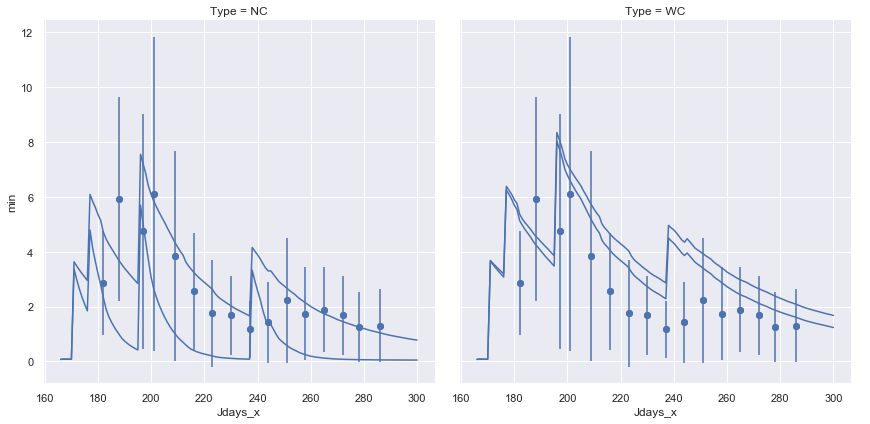

In [23]:
g = sns.FacetGrid(sets_all, col="Type", height=6)
g.map(plt.scatter, "Jdays_x", "ug.g")
g.map(plt.errorbar, "Jdays_x", "ug.g", "ug.g.SD", marker="o", linestyle='None')
g.map(plt.plot, "Jdays_x", "mean")
g.map(plt.plot, "Jdays_x", "min").add_legend()

1. Second Burger Application, there is no isotope data to make this call!!
2. There is also no isotope data to make an assumption on a second application by Friess in the North and Valley (I did not include one on the South).